In [2]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neighbors import KernelDensity 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

torch.Size([2000, 2])


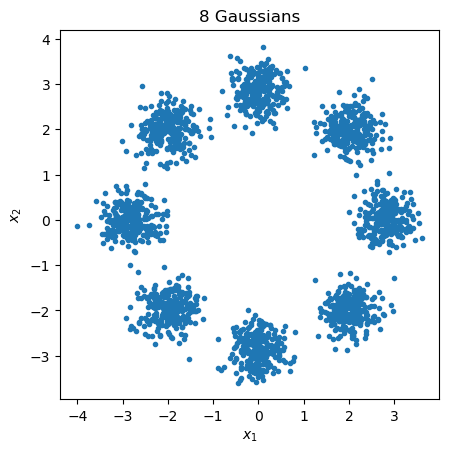

In [3]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

### Variance-exploding SDE

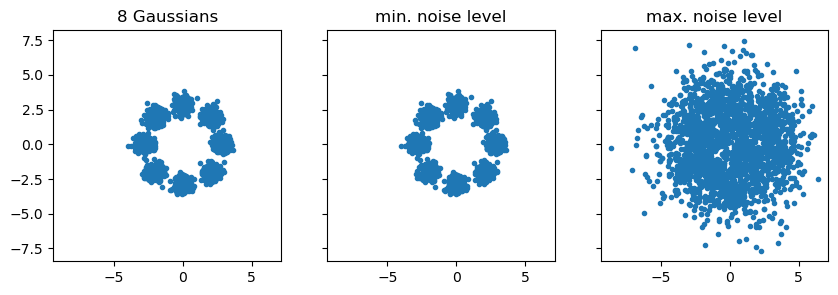

In [4]:
# decide on min/max noise level
sigma_min = 0.01
sigma_max = 1.5

def sigma_t(t):
    return sigma_min*(sigma_max/sigma_min)**t

x_noisy_min = x + sigma_min*torch.randn_like(x)
x_noisy_max = x + sigma_max*torch.randn_like(x)

fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,3))
ax[0].scatter(x[:,0],x[:,1],marker='.'), ax[0].set_title('8 Gaussians')
ax[1].scatter(x_noisy_min[:,0],x_noisy_min[:,1],marker='.'), ax[1].set_title('min. noise level')
ax[2].scatter(x_noisy_max[:,0],x_noisy_max[:,1],marker='.'), ax[2].set_title('max. noise level')
plt.show()

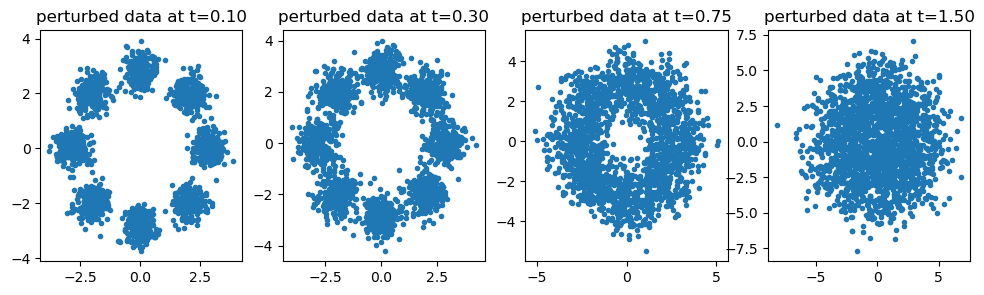

In [5]:
t_all = [0.1,0.3,0.75,1.5]

fig, ax = plt.subplots(1,len(t_all),figsize=(3*len(t_all),3))
for t_idx, t in enumerate(t_all):
    x_tmp = x + t*torch.randn_like(x)
    ax[t_idx].scatter(x_tmp[:,0],x_tmp[:,1],marker='.'), ax[t_idx].set_title('perturbed data at t=%.2f' %t)
plt.savefig(os.getcwd() + '/out/ve_sde.png', bbox_inches='tight')
plt.show()

In [6]:
# denoising score matching model
class DSM(nn.Module):
    def __init__(self, sigma_min, sigma_max, L, size_hidden, device):
        super().__init__()
        self.device = device
        self.sigma_min, self.sigma_max = sigma_min, sigma_max
        self.L = L # number of noise levels
        self.sigmas_all = self.gen_sigmas().to(self.device)

        self.W1 = nn.Linear(3, size_hidden, bias=True) # additionally condition on noise level
        self.W2 = nn.Linear(size_hidden, size_hidden, bias=True)
        self.W3 = nn.Linear(size_hidden, 2, bias=True)

    def gen_sigmas(self):
        return torch.tensor(np.exp(np.linspace(np.log(self.sigma_min),np.log(self.sigma_max), self.L))).type(torch.float32)

    def forward(self, ipt, sigma_):
        ipt_stacked = torch.hstack((ipt, sigma_))
        tmp = torch.relu(self.W1(ipt_stacked))
        tmp = torch.relu(self.W2(tmp))
        return self.W3(tmp)

    def fit(self, x, max_iter, lr):
        optim = Adam(params=self.parameters(), lr=lr)
        self.train()
        
        losses = []
        for iter_ in range(max_iter):
            # sample noise levels (disc. way here, must also work continuously)
            idx = torch.randint(0, self.L, (x.shape[0],))
            used_sigmas = (self.sigmas_all[idx][:,None])

            # add noise
            z = x + used_sigmas*torch.randn_like(x)
            
            # use Tweedie's formula for single step denoising loss
            target = 1/(used_sigmas**2)*(x-z)
            scores = self.forward(z,used_sigmas)
            loss = (used_sigmas**2*((target-scores)**2)).mean()

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())
            x = shuffle(x)
        
        return losses
    
    def sample(self, n_samples):
        # sampling - PC scheme
        samples = self.sigma_max*torch.randn(n_samples,2,device=self.device)
        sigma_t_prev = self.sigmas_all[-1]
        samples_all = []
        samples_all.append(samples.detach().clone())

        self.eval()
        with torch.no_grad():
            for i, sigma_t in enumerate(torch.flip(self.sigmas_all,dims=(0,))[1::]):
                scores = self(samples,sigma_t_prev*torch.ones((samples.shape[0],1),device=self.device))
                z = torch.randn(n_samples,2,device=self.device)
                tau = np.abs(sigma_t_prev.item()**2 - sigma_t.item()**2)

                # predictor step
                samples += tau*scores + np.sqrt(tau)*z
                sigma_t_prev = sigma_t.clone()

                samples_all.append(samples.detach().clone())
                
        return samples_all

In [7]:
max_iter = 5000
lr = 1.0E-2
size_hidden = 128
L = 200

In [8]:
dsm = DSM(sigma_min=sigma_min, sigma_max=sigma_max, L=L, size_hidden=size_hidden, device=x.device)
dsm = dsm.to(x.device)

loss = dsm.fit(x,max_iter=max_iter,lr=lr)

In [9]:
# sampling
samples = dsm.sample(n_samples=n_samples)

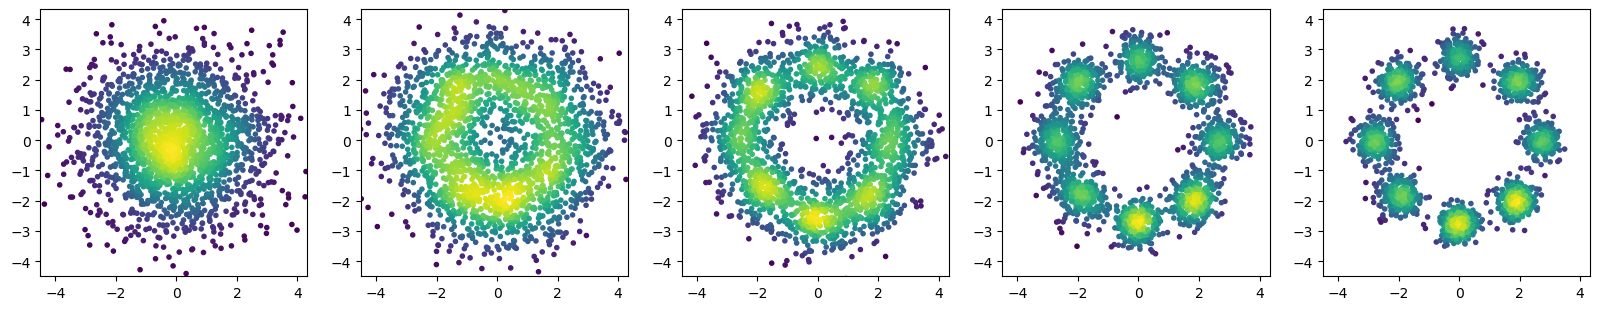

In [10]:
# make plot for different noise levels
indices = [0,20,40,70,199]
fig, ax = plt.subplots(1,len(indices),figsize=(4*len(indices),4),sharex=False,sharey=False)
for index_idx, index in enumerate(indices):
    samples_curr = samples[index].cpu().numpy()

    # fit KDE at current noise level
    kde = KernelDensity(bandwidth=.4).fit(samples_curr)
    xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
    x_grid = np.stack((xx.ravel(), yy.ravel()),1)
    density = np.exp(kde.score_samples(x_grid))
    samples_kde = np.exp(kde.score_samples(samples_curr))

    ax[index_idx].scatter(samples_curr[:,0], samples_curr[:,1],marker='.',c=samples_kde)
    ax[index_idx].set_aspect('equal')
    ax[index_idx].set_xlim([x.min().item()-0.5,x.max().item()+0.5]), ax[index_idx].set_ylim([x.min().item()-0.5,x.max().item()+0.5])
plt.savefig(os.getcwd() + '/out/diffusion.png', bbox_inches='tight')
plt.show()
